In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups
from allen_v1dd.stimulus_analysis.drifting_gratings import load_dg_xarray_from_h5
from allen_v1dd.stimulus_analysis.running_correlation import sync_running_to_response

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

In [5]:
client = OPhysClient("chase")

In [9]:
session = client.load_ophys_session("M409828_13")
plane = 0

In [67]:
for group in iter_plane_groups():
    print(group["drifting_gratings_windowed"]["pref_cond_index"].attrs["notes"])
    break

Dimension 1 (pref_cond_idx) contains [pref_dir_idx, pref_sf_idx]


In [11]:
run_speed = abs(session.get_running_speed())
running_times = run_speed.time[run_speed >= 1]
stationary_times = run_speed.time[run_speed < 1]

df = []

spont_traces = session.get_spont_traces(plane)
run_synced_abs = abs(sync_running_to_response(run_speed, spont_traces))


for group in iter_plane_groups(filter=dict(mouse=session.get_mouse_id(), column=session.get_column_id(), volume=session.get_volume_id(), plane=plane)):
    inclusion = group["is_roi_valid"] & ~group["is_ignored_duplicate"]
    dgw = group["drifting_gratings_windowed"]
    dgf = group["drifting_gratings_full"]

    for roi in np.where(inclusion)[0]:
        pref_sf_idx = dgw["pref_cond_index"][roi, 1]
        dgw_resp = np.nanmean(dgw["trial_responses"][roi, :, pref_sf_idx, :])
        dgf_resp = np.nanmean(dgf["trial_responses"][roi, :, pref_sf_idx, :])

        df.append(dict(
            session = session.get_session_id(),
            plane = plane,
            roi = roi,
            running_correlation_full = group["running_correlations"][roi],

            dgw_resp = dgw_resp,
            dgf_resp = dgf_resp
        ))


    break

df = pd.DataFrame(df)
df

<HDF5 group "/M409828/13/Plane_0" (12 members)>


In [12]:
session.get_spont_traces(0)

<xarray.DataArray 'spont_events' (roi: 1234, time: 1820)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04122025, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)
Coordinates:
  * roi      (roi) int64 0 1 2 3 4 5 6 7 ... 1227 1228 1229 1230 1231 1232 1233
  * time     (time) float64 876.5 876.6 876.8 ... 1.176e+03 1.176e+03 1.176e+03

In [20]:
running_times

<xarray.DataArray 'time' (time: 82315)>
array([  52.5967 ,   52.61287,   52.8964 , ..., 3539.18257, 3539.46614,
       3539.48283])
Coordinates:
  * time     (time) float64 52.6 52.61 52.9 ... 3.539e+03 3.539e+03 3.539e+03

468 1352


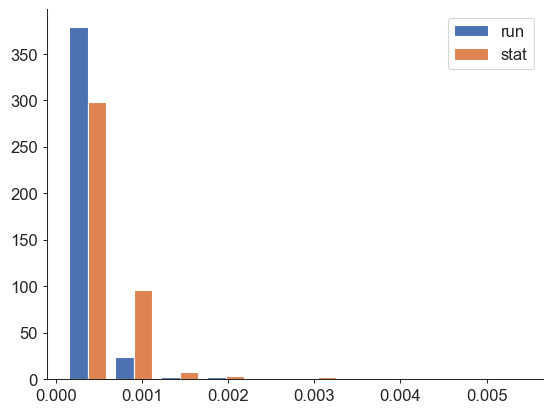

In [55]:

run_speed = session.get_running_speed()
spont_traces = session.get_spont_traces(plane)
synced_run_speed = abs(sync_running_to_response(run_speed, spont_traces))
running_times = synced_run_speed.time[synced_run_speed >= 1]
stationary_times = synced_run_speed.time[synced_run_speed < 1]
print(len(running_times), len(stationary_times))

roi_mean_spont_run = spont_traces.sel(time=running_times).mean(dim="time").values
roi_mean_spont_stat = spont_traces.sel(time=stationary_times).mean(dim="time").values

incl = session.is_roi_valid(plane)

plt.hist([roi_mean_spont_run[incl], roi_mean_spont_stat[incl]], label=["run", "stat"])
plt.legend()